# Kernel Prep (if required)

In [1]:
## Run this only once to create a Julia kernel with access to multiple threads. 
##Then reload the Jupyter environment and select the new kernel.
# using IJulia
# IJulia.installkernel("Julia 8 Threads", env=Dict(
#     "JULIA_NUM_THREADS" => "8",
# ))

In [2]:
VERSION

v"1.9.2"

In [3]:
# check the available threads for parallelisation later
Threads.nthreads()

8

# Imports

In [34]:
import Pkg

In [35]:
Pkg.add(["BenchmarkTools", "CpuId", "Random", "LinearAlgebra", "DataFrames"])

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [36]:
using CpuId
using Random
using BenchmarkTools
using LinearAlgebra
using DataFrames

In [7]:
versioninfo()

Julia Version 1.9.2
Commit e4ee485e90 (2023-07-05 09:39 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: 8 × Intel(R) Core(TM) i7-4790K CPU @ 4.00GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, haswell)
  Threads: 9 on 8 virtual cores
Environment:
  JULIA_IMAGE_THREADS = 1
  JULIA_NUM_THREADS = 8


# Check CPU info

In [8]:
cpuinfo()

| Cpu Property       | Value                                                      |
|:------------------ |:---------------------------------------------------------- |
| Brand              | Intel(R) Core(TM) i7-4790K CPU @ 4.00GHz                   |
| Vendor             | :Intel                                                     |
| Architecture       | :Haswell                                                   |
| Model              | Family: 0x06, Model: 0x3c, Stepping: 0x03, Type: 0x00      |
| Cores              | 4 physical cores, 8 logical cores (on executing CPU)       |
|                    | Hyperthreading hardware capability detected                |
| Clock Frequencies  | Not supported by CPU                                       |
| Data Cache         | Level 1:3 : (32, 256, 8192) kbytes                         |
|                    | 64 byte cache line size                                    |
| Address Size       | 48 bits virtual, 39 bits physical                          |
| SIMD               | 256 bit = 32 byte max. SIMD vector size                    |
| Time Stamp Counter | TSC is accessible via `rdtsc`                              |
|                    | TSC runs at constant rate (invariant from clock frequency) |
| Perf. Monitoring   | Performance Monitoring Counters (PMC) revision 3           |
|                    | Available hardware counters per logical core:              |
|                    | 3 fixed-function counters of 48 bit width                  |
|                    | 4 general-purpose counters of 48 bit width                 |
| Hypervisor         | No                                                         |


# Raw data

The raw data will consist of two 1D arrays of 1 million random numbers selected from a normal distribution

In [9]:
rng1 = MersenneTwister(12);
rng2 = MersenneTwister(42);

In [10]:
rand_array1 = randn(rng1, Float32, 1000000);
rand_array2 = randn(rng2, Float32, 1000000);

In [11]:
rand_array1

1000000-element Vector{Float32}:
 -0.21829714
 -1.7218448
  0.60371566
 -0.21179752
  2.013316
  0.7635311
 -0.09813517
  0.14246899
 -2.8935103
  0.2712585
  0.49524835
 -0.24905972
 -0.67601675
  ⋮
  0.5426831
  0.5685537
  1.0198451
  0.98203737
  3.535167
 -0.9696251
 -0.27069858
  0.067558266
  0.42905912
 -0.6189855
  1.7335621
  0.886588

In [12]:
rand_array2

1000000-element Vector{Float32}:
 -0.5560269
 -0.44438335
  0.027155338
 -0.2994841
  1.7778611
 -1.1449015
 -0.46860588
  0.15614346
 -2.641991
  1.0033098
  1.0823812
  0.1870279
  0.5181488
  ⋮
  0.16583896
  1.5055028
  0.29621014
  0.25566205
  0.52386904
 -0.029327773
  0.18073075
  0.19753174
  1.027893
  0.25698507
 -2.2207909
  0.31266758

## A very simple arithmetic based method

The aim of the following methods is a very simple summation of the two arrays.

In [13]:
function sum_nums(a::Vector{Float32}, b::Vector{Float32})
    return a + b
end

sum_nums (generic function with 1 method)

In [88]:
@benchmark sum_nums($rand_array1, $rand_array2) samples=1

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 730.568 μs (0.00% GC) to evaluate,
 with a memory estimate of 3.81 MiB, over 2 allocations.

In [89]:
@benchmark sum_nums($rand_array1, $rand_array2) samples=10000

BenchmarkTools.Trial: 6789 samples with 1 evaluation.
 Range (min … max):  632.486 μs …   2.556 ms  ┊ GC (min … max): 0.00% … 45.09%
 Time  (median):     657.529 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   723.853 μs ± 257.043 μs  ┊ GC (mean ± σ):  7.81% ± 13.47%

  █▇▆▅▃▁                                                    ▂▂▁ ▁
  ███████▇▇▅▅▆▃▃▄▄▄▄▃▄▃▃▁▁▁▃▁▁▁▁▁▁▁▁▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███ █
  632 μs        Histogram: log(frequency) by time       1.85 ms <

 Memory estimate: 3.81 MiB, allocs estimate: 2.

In [92]:
results_simple = DataFrame(julia=[0.73,0.72], numpy=[0.78,0.51], numba_inc_comp=[84.10,0.54], numba_exc_comp=[0.83,0.53])

Row,julia,numpy,numba_inc_comp,numba_exc_comp
,Float64,Float64,Float64,Float64
1,0.73,0.78,84.1,0.83
2,0.72,0.51,0.54,0.53


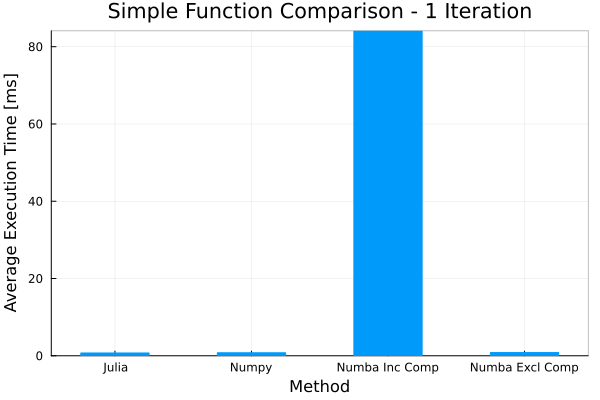

In [94]:
using StatsPlots
bar(["Julia", "Numpy", "Numba Inc Comp", "Numba Excl Comp"],Vector(results_simple[1,1:4]),
    title = "Simple Function Comparison - 1 Iteration", 
    xlabel = "Method",
    ylabel = "Average Execution Time [ms]",
    legend = false,
    bar_width = 0.50,
    linecolor = :match,
    grid = true,
    framestyle=:semi
    )

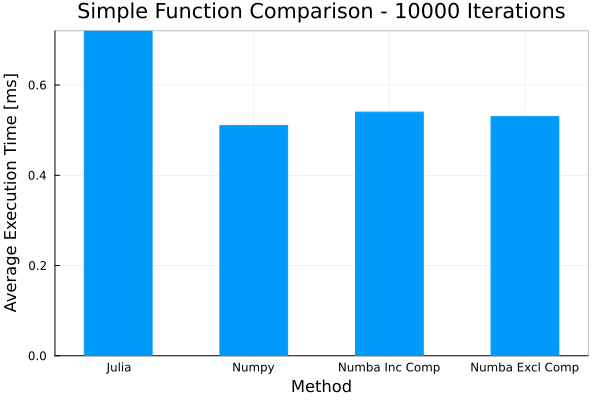

In [95]:
using StatsPlots
bar(["Julia", "Numpy", "Numba Inc Comp", "Numba Excl Comp"],Vector(results_simple[2,1:4]),
    title = "Simple Function Comparison - 10000 Iterations", 
    xlabel = "Method",
    ylabel = "Average Execution Time [ms]",
    legend = false,
    bar_width = 0.50,
    linecolor = :match,
    grid = true,
    framestyle=:semi
    )

## Loops

In [15]:
# normal Julia function
function loop_function(a::Vector{Float32}, b::Vector{Float32})
    c::Vector{Float32} = zeros(Float32, size(a))
    for i = 1:size(c)[1]
        a[i] < b[i] ? c[i] = 1.0 : c[i] = 2.0
	end
	return c, a + b
end

# parallelised Julia function
function loop_function_para(a::Vector{Float32}, b::Vector{Float32})
    c::Vector{Float32} = zeros(Float32, size(a))
    Threads.@threads for i = 1:size(c)[1]
        a[i] < b[i] ? c[i] = 1.0 : c[i] = 2.0
	end
	return c, a + b
end

loop_function_para (generic function with 1 method)

### Test the function output

In [16]:
test1 = loop_function(rand_array1, rand_array2)

(Float32[2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0  …  2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0], Float32[-0.774324, -2.166228, 0.630871, -0.5112816, 3.791177, -0.38137043, -0.56674105, 0.29861245, -5.5355015, 1.2745683  …  1.3160553, 1.2376994, 4.0590363, -0.99895287, -0.08996783, 0.26509002, 1.4569521, -0.3620004, -0.48722875, 1.1992556])

In [17]:
# check the available threads for parallelisation later
Threads.nthreads()

8

In [18]:
test2 = loop_function_para(rand_array1, rand_array2)

(Float32[2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0  …  2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0], Float32[-0.774324, -2.166228, 0.630871, -0.5112816, 3.791177, -0.38137043, -0.56674105, 0.29861245, -5.5355015, 1.2745683  …  1.3160553, 1.2376994, 4.0590363, -0.99895287, -0.08996783, 0.26509002, 1.4569521, -0.3620004, -0.48722875, 1.1992556])

### Run benchmarks

In [96]:
@benchmark loop_function($rand_array1, $rand_array2) samples=1

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 4.345 ms (0.00% GC) to evaluate,
 with a memory estimate of 7.63 MiB, over 4 allocations.

In [97]:
@benchmark loop_function($rand_array1, $rand_array2) samples=100

BenchmarkTools.Trial: 100 samples with 1 evaluation.
 Range (min … max):  4.209 ms …   6.745 ms  ┊ GC (min … max): 0.00% … 16.87%
 Time  (median):     4.243 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.454 ms ± 525.287 μs  ┊ GC (mean ± σ):  2.53% ±  6.07%

  █▄                                                           
  ███▁▆▄▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▇█▁▄▆▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄ ▄
  4.21 ms      Histogram: log(frequency) by time      6.72 ms <

 Memory estimate: 7.63 MiB, allocs estimate: 4.

In [98]:
@benchmark loop_function_para($rand_array1, $rand_array2) samples=100

BenchmarkTools.Trial: 100 samples with 1 evaluation.
 Range (min … max):  1.622 ms …   2.886 ms  ┊ GC (min … max): 0.00% … 39.92%
 Time  (median):     1.652 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.780 ms ± 362.983 μs  ┊ GC (mean ± σ):  6.50% ± 12.29%

  ▆█▂                                                          
  ███▄▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▃ ▂
  1.62 ms         Histogram: frequency by time        2.86 ms <

 Memory estimate: 7.63 MiB, allocs estimate: 53.

In [101]:
results_loop = DataFrame(julia=[4.45], julia_para=[1.78], numpy=[267.63], numba_inc_comp=[3.81], numba_exc_comp=[2.52], numba_para_inc_comp=[3.56], numba_para_exl_comp=[1.02],numba_para_fastmath_exl_comp=[0.89])

Row,julia,julia_para,numpy,numba_inc_comp,numba_exc_comp,numba_para_inc_comp,numba_para_exl_comp,numba_para_fastmath_exl_comp
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,4.45,1.78,267.63,3.81,2.52,3.56,1.02,0.89


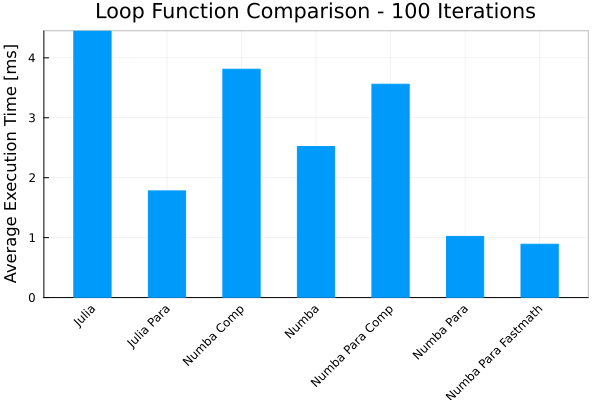

In [102]:
using StatsPlots
bar(["Julia", "Julia Para","Numba Comp", "Numba", "Numba Para Comp", "Numba Para", "Numba Para Fastmath"],Vector(select(results_loop, Not(:numpy))[1,1:7]),
    title = "Loop Function Comparison - 100 Iterations", 
    xlabel = "Method",
    ylabel = "Average Execution Time [ms]",
    legend = false,
    bar_width = 0.50,
    linecolor = :match,
    grid = true,
    framestyle=:semi,
    xrotation = 45
    )

# Matrix manipulation

In [21]:
matrix1 = randn(rng1, Float32, 10000);
matrix1 = reshape(matrix1,(100,100))

100×100 Matrix{Float32}:
  1.0949       2.2867     -0.0145377  …  -1.59276    -0.252202    0.890795
  1.03778     -0.0360797   2.34713        0.429299   -1.00341     0.434615
 -1.22476      1.40377     0.401261       1.67853    -0.737117   -0.337081
  0.122094    -0.358374    1.89313        1.25809    -0.259544   -0.298944
 -1.53        -2.28184     0.752398       0.807518    1.2386      1.36792
 -0.314696     0.715392   -0.259901   …   0.671572    1.35636    -0.639937
  0.107885     0.201307    0.758648      -2.16464     0.0946744  -0.277191
  0.912583     0.0333038  -1.1437         1.43687    -0.18857    -0.144484
  0.986553    -0.40483     1.65629       -1.07122    -0.670125    1.3244
  0.270327     0.634046    1.67961        0.195576   -0.788613   -0.365198
 -2.16125     -0.314807    0.774918   …   0.873663    0.183299    0.849183
  0.0114741    0.215262   -0.591649       1.97035     0.330857    0.0435898
 -0.288804    -1.05299     0.317931       0.373275   -0.0181475   0.196969
  

In [22]:
matrix2 = randn(rng2, Float32, 10000);
matrix2 = reshape(matrix2,(100,100))

100×100 Matrix{Float32}:
 -0.0844835  -2.41718     0.633981  …  -0.26323     0.0829653   0.35989
 -1.01409     1.6598      0.189985      0.313934   -0.755913   -0.0992447
  0.106495   -0.028786    0.675925      1.65781    -0.167978    0.340021
  0.259342    1.34346    -1.00815       0.621243    2.37121    -0.268835
 -1.52307    -0.470214   -1.68885       0.42349     0.250247   -0.75887
 -0.749934    1.14591     1.12622   …  -1.22809    -1.3289      0.476954
 -0.380714    1.19585     0.130052      0.523867    2.09346    -1.72058
  1.03333     1.08411     1.09851       0.288951    0.712317    0.341738
  1.18261     0.808248   -1.4035       -2.07384     0.147078   -0.644912
  0.191078   -0.190436    0.116673      0.0139102   0.780891    1.47451
  0.153024    0.630641   -0.47303   …   0.143771   -1.19761     0.0379208
 -1.03079     2.2249      1.31339       1.01469     1.92207    -0.337193
 -0.592289   -0.0458845   0.570861     -3.18685    -1.30513     0.0263227
  ⋮                        

In [66]:
function matrix_func(mat_a, mat_b)
    a = mat_a'
    c = mat_b * a
    d = reshape(c,(50,50,4))
    e = reshape(mat_b,(50,4,50))
    f = reshape(d,(200,50))
    g = reshape(e,(50,200))
    h = f * g
    i = reshape(h,40000)
    result = 0.0
    for j = 1:size(i)[1]
        result = result + (i[j] - sum(i)) / sqrt(abs(mean(i)))
    end
    return result
end

matrix_func (generic function with 1 method)

In [67]:
matrix_func(matrix1,matrix2)

-6.449281995957031e8

In [103]:
@benchmark matrix_func($matrix1, $matrix2) samples=20

BenchmarkTools.Trial: 20 samples with 1 evaluation.
 Range (min … max):  199.991 ms … 217.927 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     201.369 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   204.339 ms ±   6.005 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▄█ ▁                                                         
  ▆▆██▆█▆▆▁▁▁▆▁▁▁▁▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▁▁▁▆▁▁▆▁▁▁▁▁▆ ▁
  200 ms           Histogram: frequency by time          218 ms <

 Memory estimate: 195.73 KiB, allocs estimate: 10.

In [69]:
function matrix_func_para(mat_a, mat_b)
    a = mat_a'
    c = mat_b * a
    d = reshape(c,(50,50,4))
    e = reshape(mat_b,(50,4,50))
    f = reshape(d,(200,50))
    g = reshape(e,(50,200))
    h = f * g
    i = reshape(h,40000)
    result = 0.0
    Threads.@threads for j = 1:size(i)[1]
        result = result + (i[j] - sum(i)) / sqrt(abs(mean(i)))
    end
    return result
end

matrix_func_para (generic function with 1 method)

In [104]:
@benchmark matrix_func_para($matrix1, $matrix2) samples=20

BenchmarkTools.Trial: 20 samples with 1 evaluation.
 Range (min … max):  42.532 ms … 53.686 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     43.685 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   44.565 ms ±  2.737 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▁   ▄▄                                                      
  ██▁▁▆██▁▆▁▁▆▆▁▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▆▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆ ▁
  42.5 ms         Histogram: frequency by time        53.7 ms <

 Memory estimate: 1.42 MiB, allocs estimate: 80061.

In [105]:
results_matrix = DataFrame(julia=[204.34], julia_para=[44.57], numba_inc_comp=[2069.57], numba_exc_comp=[2059.81], numba_para_inc_comp=[316.76], numba_para_exl_comp=[303.46])

Row,julia,julia_para,numba_inc_comp,numba_exc_comp,numba_para_inc_comp,numba_para_exl_comp
,Float64,Float64,Float64,Float64,Float64,Float64
1,204.34,44.57,2069.57,2059.81,316.76,303.46


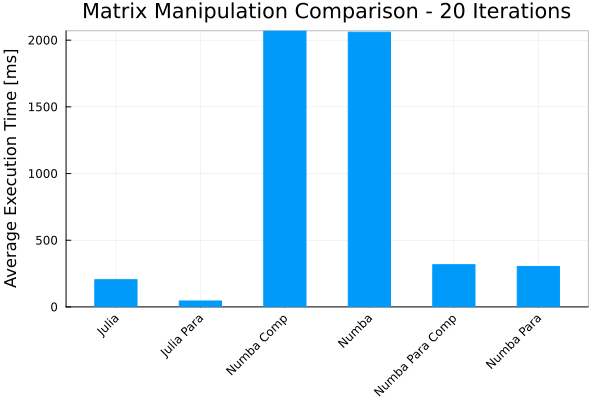

In [106]:
using StatsPlots
bar(["Julia", "Julia Para","Numba Comp", "Numba", "Numba Para Comp", "Numba Para"],Vector(results_matrix[1,1:6]),
    title = "Matrix Manipulation Comparison - 20 Iterations", 
    xlabel = "Method",
    ylabel = "Average Execution Time [ms]",
    legend = false,
    bar_width = 0.50,
    linecolor = :match,
    grid = true,
    framestyle=:semi,
    xrotation = 45
    )